In [1]:
import numpy.random as random
import jax.numpy as np
from tqdm import tqdm
from jax import vmap, grad, jit
import matplotlib.pyplot as plt
from cycler import cycler
import cvxpy as cp
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica Neue"],
    "font.size": 28,
    #  "contour.negative_linestyle": 'solid',
})
plt.rc('axes', prop_cycle=cycler('linestyle', ['-', '--', ':', '-.']))

In [2]:
# Problem data
random.seed(1)
m, n = 100, 500
A = random.randn(m, n)
b = random.randn(m)
lam = 4

def f(x):
    return .5 * np.linalg.norm(np.dot(A, x) - b, 2)**2 + \
        lam * np.linalg.norm(x, 1)


def soft_thresh(x, mu):
    return np.maximum(x - mu, 0) - \
        np.maximum(-x - mu, 0)


f = jit(f)
f_prime = jit(grad(f))

k_vec = np.arange(1000)

x0 = random.randn(n)

In [3]:
# Solve with cvxpy
x_cp = cp.Variable(n)
f_star = cp.Problem(
    cp.Minimize(.5 * cp.sum_squares(A @ x_cp - b) + lam * cp.norm(x_cp, 1))
).solve(solver=cp.ECOS, abstol=1e-10, reltol=1e-10)
x_star = x_cp.value

In [4]:
# Subgradient
step_size_rules = [#lambda k: 0.01/np.sqrt(k+1),
                   lambda k: 0.001/np.sqrt(k+1),
                   lambda k: 0.01/(k + 1),
                   ]
step_size_rules_str = [#r"$0.01/\sqrt{k+1}$",
                       r"$0.0005/\sqrt{k+1}$",
                       r"$0.005/(k+1)$",
                       ]
x_hist_adapt = {}
subopt_hist_adapt = {}
for i, t in enumerate(tqdm(step_size_rules)):
    x_hist_adapt[i] = [x0]
    f_best = f(x0)
    subopt_hist_adapt[i] = [(f_best - f_star)/f_star]

    for k in k_vec:
        x_next = x_hist_adapt[i][-1] - t(k) * f_prime(x_hist_adapt[i][-1])
        x_hist_adapt[i].append(x_next)
        f_next = f(x_next)
        if f_next < f_best:
            f_best = f_next

        subopt_hist_adapt[i].append((f_best - f_star)/f_star)

x_hist_polyak = [x0]
f_best = f(x0)
f_next = f(x0)
subopt_hist_polyak = [(f_best - f_star)/f_star]
for k in k_vec:
    f_current = f_next
    g = f_prime(x_hist_polyak[-1])
    t = (f_current - f_star) / np.linalg.norm(g)**2
    x_next = x_hist_polyak[-1] - t * g
    x_hist_polyak.append(x_next)
    f_next = f(x_next)
    if f_next < f_best:
        f_best = f_next

    subopt_hist_polyak.append((f_best - f_star)/f_star)

100%|████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.56it/s]


In [5]:
# ISTA
x_hist_ista = [x0]
subopt_hist_ista = [(f(x0) - f_star)/f_star]
t_ista = 0.001
for k in k_vec:
    x_cur = x_hist_ista[-1]
    x_next = x_cur - t_ista * A.T.dot(A.dot(x_cur) - b)
    x_next = soft_thresh(x_next, t_ista * lam)
    x_hist_ista.append(x_next)
    subopt_hist_ista.append((f(x_next) - f_star)/f_star)
    # NB. For plotting, not realistic termination
    if subopt_hist_ista[-1] < 1e-06:
        break

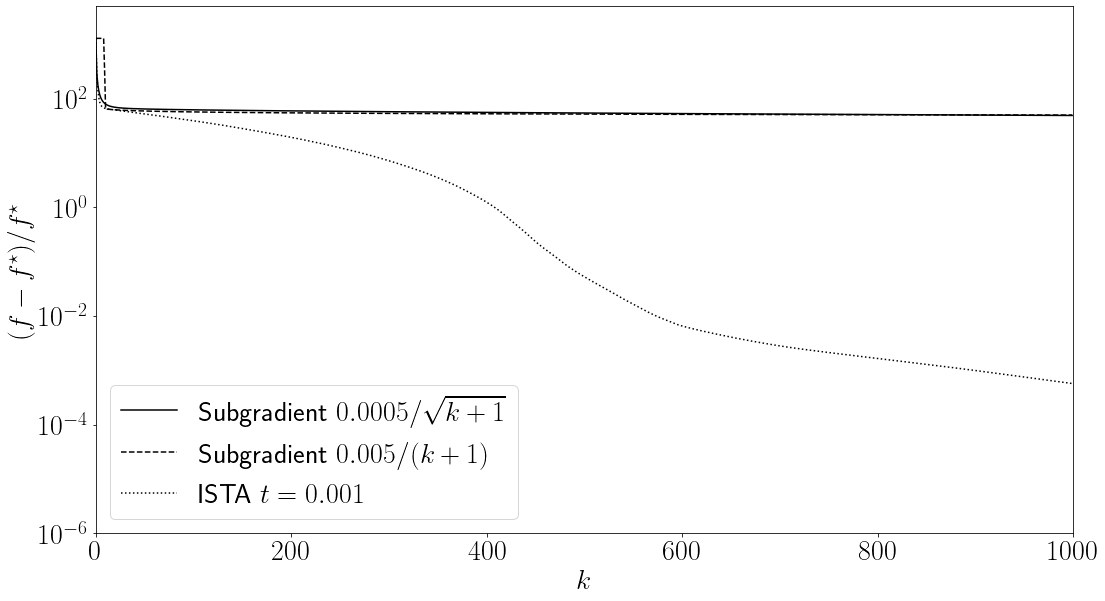

In [6]:
# Plot
fig, ax = plt.subplots(figsize=(16, 9))

for i, _ in enumerate(step_size_rules):
    ax.plot(k_vec, subopt_hist_adapt[i][:-1], color="k",
            label=r"$\mbox{Subgradient}\;$" + step_size_rules_str[i])
#  ax.plot(k_vec, subopt_hist_polyak[:-1], color="k",
#          label=r"$\mbox{Polyak}$")
ax.plot(k_vec, subopt_hist_ista[:-1], color="k",
        label=r"$\mbox{ISTA}\;t = %.3f$" % t_ista)
ax.set_yscale('log')
ax.set_ylabel(r"$(f - f^\star)/f^\star$")
ax.set_xlabel(r"$k$")
ax.set_xlim([0, 1000])
ax.set_ylim([1e-06, 5e03])
ax.legend()


plt.tight_layout()
plt.savefig("ista_cvx.pdf")
